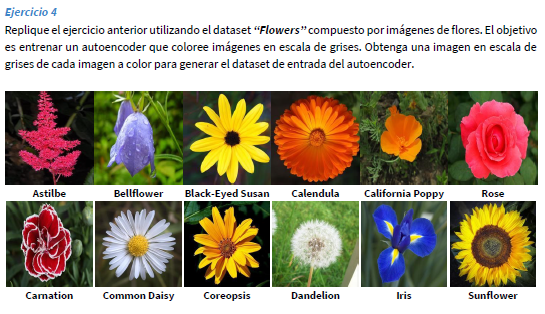
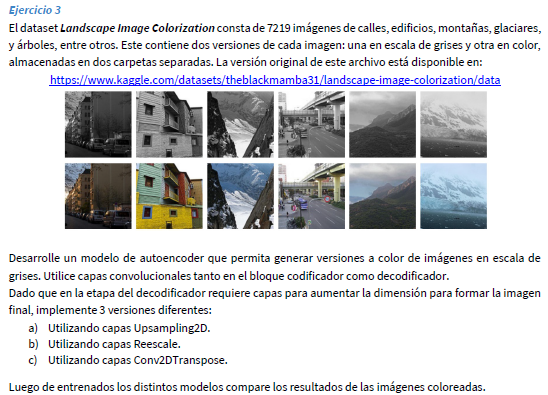

## Configuro notebook

In [2]:
# configuración para notebook con instalación LOCAL
FUENTES_DIR  = '../../Datos-Fuentes/Fuentes/'     # carpeta donde se encuentran archivos .py auxiliares
DATOS_DIR    = '../../Datos-Fuentes/Datos/'      # carpeta donde se encuentran los datasets
MODELOS_DIR  = '../../Modelos/'    # carpeta donde se encuentran los modelos
ARCHIVOs_DIR = '../Archivos/'   # carpeta recuperar o copiar archivos

# agrega ruta de busqueda donde tenemos archivos .py
import sys
sys.path.append(FUENTES_DIR)

## Importo paquetes

In [3]:
import numpy as np
import re
import matplotlib.pyplot as plt
import os
import shutil
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.image import img_to_array
from tqdm import tqdm
from zipfile import ZipFile
from PIL import Image
import glob

## Preparo datos

In [4]:
SIZE = 96  # Tamaño de la imagen que será procesada por la red
GRAY_CHANNELS = 1
color_img = []
gray_img = []

ruta_color = 'FlowersX16/'
# ruta_grises = 'landscape Images/gray/'

archivos = glob.glob(DATOS_DIR + ruta_color + '/*/*.jpg')

for ruta_arch in tqdm(archivos):
    # Imagen en color
    img_color = Image.open(ruta_arch)
    img_color = img_color.convert('RGB')  # Convertir a formato RGB si no lo está
    img_color = img_color.resize((SIZE, SIZE))  # Cambiar tamaño
    img_color = np.array(img_color)  # Convertir a arreglo numpy
    img_color = img_color.astype('float32') / 255.0  # Normalizar
    color_img.append(img_color)

    # Imagen en escala de grises
    ruta_gris = ruta_arch.replace('color', 'gray')
    img_gray = Image.open(ruta_gris)
    img_gray = img_gray.resize((SIZE, SIZE))  # Cambiar tamaño

    if GRAY_CHANNELS == 3:
        if img_gray.mode != 'RGB':
            img_gray = img_gray.convert('RGB')
        else:
            pass
    elif img_gray.mode != 'L':
            img_gray = img_gray.convert('L')
            # print('convirtio')
    img_gray = np.array(img_gray)  # Convertir a arreglo numpy
    img_gray = img_gray.astype('float32') / 255.0  # Normalizar
    #img_gray = np.expand_dims(img_gray, axis=-1)  # Agregar dimensión de canal
    gray_img.append(img_gray)

print(img_gray.shape)

100%|██████████| 15740/15740 [00:41<00:00, 383.00it/s]

(96, 96)


## Grafico algunas imagenes color vs gray

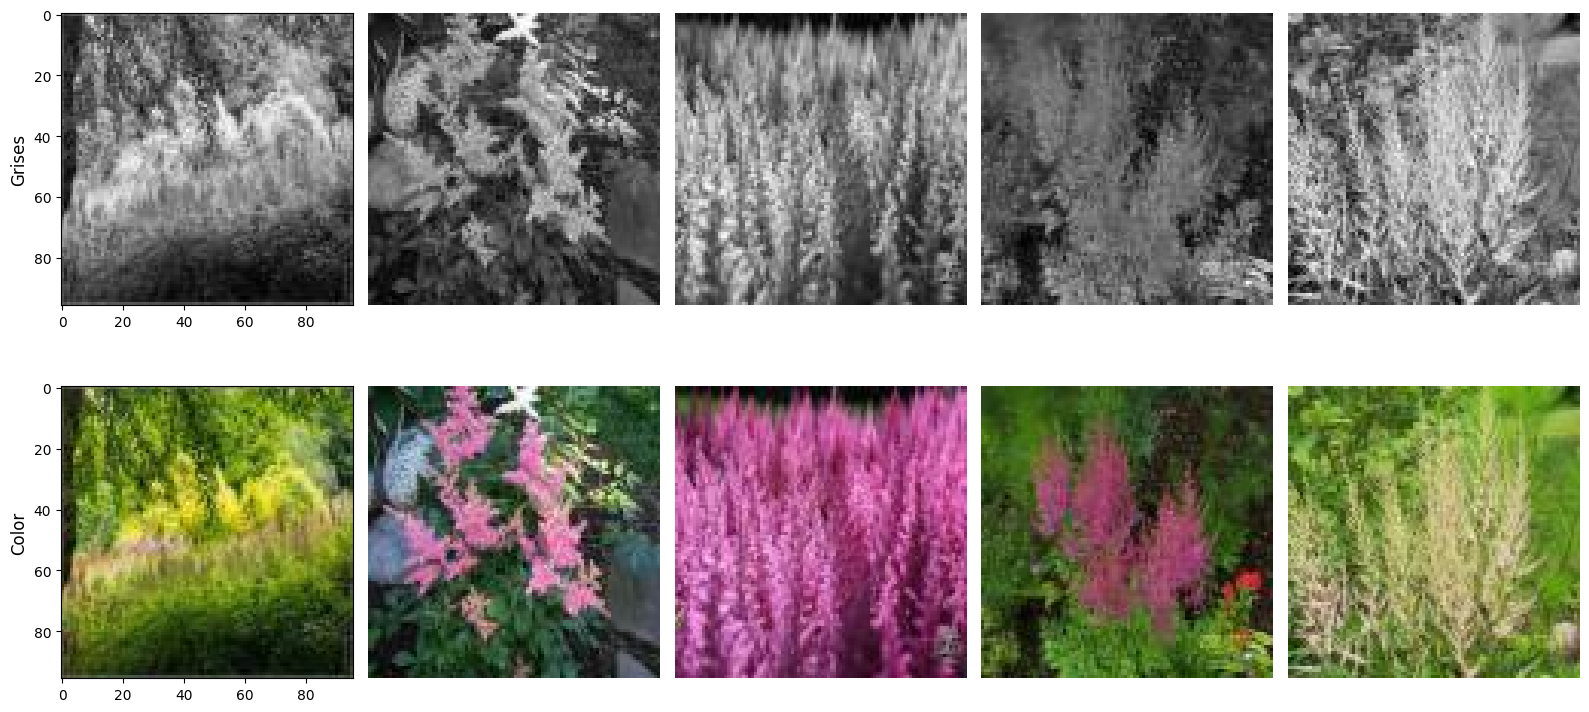

(96, 96)

In [6]:
# Definir una función para mostrar imágenes en dos filas
def plot_images(grayscale_images, color_images, num_images):

    fig, axes = plt.subplots(2, num_images, figsize=(16, 8))

    # Dibujar imágenes en escala de grises en la segunda fila
    for i in range(num_images):
        axes[0, i].imshow(grayscale_images[i], cmap='gray')
        #axes[1, i].set_title('Grayscale Image', color='black', fontsize=12)
        axes[0, i].axis('off')

    # Dibujar imágenes en color en la primera fila
    for i in range(num_images):
        axes[1, i].imshow(color_images[i])
        #axes[0, i].set_title('Color Image', color='green', fontsize=12)
        axes[1, i].axis('off')

    # Agregar títulos
    axes[0, 0].set_ylabel('Grises' , fontsize=12)
    axes[1, 0].set_ylabel('Color', fontsize=12)
    axes[0, 0].axis('on')
    axes[1, 0].axis('on')


    plt.tight_layout()
    plt.show()

plot_images(gray_img, color_img, 5)
gray_img[0].shape

## Separo en train y test

In [7]:
NUM_IMGS = len(gray_img)
NUM_TRAIN = int(NUM_IMGS * 0.9)


train_gray_img = gray_img[:NUM_TRAIN]
train_color_img = color_img[:NUM_TRAIN]

test_gray_img = gray_img[NUM_TRAIN:]
test_color_img = color_img[NUM_TRAIN:]

# estructura para dar formato para procesar por la red
train_gray_img = np.reshape(train_gray_img, (-1, SIZE, SIZE, GRAY_CHANNELS))
train_color_img = np.reshape(train_color_img, (-1, SIZE, SIZE, 3))
print('Shape de imagenes de entrenamiento:', train_color_img.shape)

test_gray_img = np.reshape(test_gray_img, (len(test_gray_img), SIZE, SIZE, GRAY_CHANNELS))
test_color_img = np.reshape(test_color_img, (-1, SIZE, SIZE, 3))
print('Shape de imagenes de prueba.......:', test_color_img.shape)

Shape de imagenes de entrenamiento: (14166, 96, 96, 3)
Shape de imagenes de prueba.......: (1574, 96, 96, 3)


## Callback para visualizar

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import Callback
from IPython import display
import io
import base64
import random

class ImageVisualizer(Callback):
    """
    Callback para visualizar imágenes durante el entrenamiento de un modelo.

    Parameters:
        model (Model): El modelo de Keras que se está entrenando.
        in_images (ndarray): Las imágenes de entrada.
        ref_images (ndarray, optional): Las imágenes de referencia. Por defecto es None.
        show_images (int, optional): Número de imágenes a mostrar. Por defecto es 5.
        interval (int, optional): Intervalo de épocas para actualizar las imágenes. Por defecto es 1.
        draw_input (bool, optional): Si se deben dibujar las imágenes de entrada. Por defecto es False.
        fig_size (tuple, optional): Tamaño de la figura. Si es None, se calcula automáticamente. Por defecto es None.
    """
    def __init__(self, model, in_images, ref_images=None, show_images=5, interval=1, draw_input=False, fig_size=None):
        super(ImageVisualizer, self).__init__()
        plt.ioff()
        self.model = model
        self.images = in_images
        self.ref_images = ref_images
        self.show_images = show_images
        self.interval = interval
        self.draw_input = draw_input

        (num_rows, num_cols) = (1 + draw_input + (ref_images is not None)*1, show_images)
        if fig_size is None:
            fig_size = (num_cols * 2.5, num_rows * 3)

        self.fig, self.ax = plt.subplots(num_rows, num_cols, figsize=fig_size, squeeze=False)

        self.display_obj = display.display(display.HTML(''), display_id = True)


    def _update_output(self):
        # Guarda el gráfico en un búfer de memoria
        buf = io.BytesIO()
        self.fig.savefig(buf, format='png')
        buf.seek(0)

        # Codifica el gráfico en base64
        image_base64 = base64.b64encode(buf.read()).decode('utf-8')

        data = {'image/png': image_base64}
        # Actualizar el gráfico
        display.update_display(data, raw=True, display_id=self.display_obj.display_id)

    def _plot_image(self, ax, title, img):
        """
        Dibuja una imagen en un eje específico.

        Parameters:
            ax (Axes): El eje en el que se dibujará la imagen.
            title (str): El título de la imagen.
            img (ndarray): La imagen a dibujar.
        """

        cmap = 'gray' if img.shape[-1] == 1 else None

        # Normalizar imagen original
        img = img.squeeze()
        if img.max() > 1:
            img = img / 255.0

        ax.imshow(img, cmap=cmap)
        ax.set_title(title)
        ax.axis('off')

    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.interval == 0:
            output_row =  1 if self.draw_input else 0
            refer_row = output_row +1
            rnd_idx = random.sample(range(len(self.images)), self.show_images)
            inp_imgs = self.images[rnd_idx]
            ref_imgs = self.ref_images[rnd_idx]
            #
            output_imgs = self.model.predict(inp_imgs, verbose=False)

            for i in range(self.show_images):

                if self.draw_input:
                    self._plot_image(self.ax[0, i], 'Input', inp_imgs[i])

                # mostrar imagen de salida
                self._plot_image(self.ax[output_row, i], 'Output', output_imgs[i])

                if self.ref_images is not None:
                    self._plot_image(self.ax[refer_row, i], 'Reference', ref_imgs[i])

            # Agregar título general con el número de época
            title_parts = [f"Época {epoch}"]

            for metric, value in logs.items():
                if metric != 'batch' and metric != 'size':  # Excluir métricas no deseadas
                    title_parts.append(f"{metric.capitalize()}: {value:.4f}")

            self.fig.text(0.5, 0.05, " - ".join(title_parts), ha='center', va='bottom', fontsize=14,
                          bbox=dict(facecolor='white', edgecolor='none', pad=5, alpha=1.0)
                         )
            self._update_output()

    def on_train_end(self, logs=None):
        plt.close()

## **Construccion del modelo**

Construye el modelo utilizando capas convolucionales que reducen el tamaño de la imagen a través del stride e incrementan la cantidad de filtros hasta llegar al espacio de representación latente. Luego se realiza el proceso inverso agregando capas convolucionales que decrementan la cantidad de filtros y capas de Upsampling para ir recuperando el tamaño de la imagen al original.

In [9]:
import tensorflow as tf

def saturation_loss(y_true, y_pred):
    # Convertir las imágenes de RGB a HSV
    y_true_hsv = tf.image.rgb_to_hsv(y_true)
    y_pred_hsv = tf.image.rgb_to_hsv(y_pred)

    # Extraer la saturación (segunda canal en HSV)
    saturation_true = y_true_hsv[:, :, :, 1]
    saturation_pred = y_pred_hsv[:, :, :, 1]

    # Calcular la diferencia de saturación
    saturation_diff = tf.abs(saturation_true - saturation_pred)

    # Promediar la diferencia de saturación en todas las imágenes
    saturation_loss = tf.reduce_mean(saturation_diff)

    return saturation_loss


def total_loss(y_true, y_pred):
    mse_loss = tf.reduce_mean(tf.square(y_true - y_pred))
    sat_loss = saturation_loss(y_true, y_pred)

    # Combinar las pérdidas (puedes ajustar los pesos según sea necesario)
    total_loss = mse_loss + 0.2 * sat_loss  # Ajusta el peso de la pérdida de saturación

    return total_loss

In [10]:
from  tensorflow.keras import models
import tensorflow as tf
from tensorflow.keras import mixed_precision


def crear_modelo1(img_h, img_w, img_ch, activ='relu', filt=128):
    # codificador
    inputs1 = layers.Input(shape=(img_h, img_w, img_ch,))
    encoder_output = layers.Conv2D(filt, (3,3), activation=activ, padding='same', strides=2)(inputs1)
    encoder_output = layers.Conv2D(2*filt, (3,3), activation=activ, padding='same', strides=2)(encoder_output)
    encoder_output = layers.Conv2D(4*filt, (3,3), activation=activ, padding='same')(encoder_output)

    # decodificador
    decoder_output = layers.Conv2D(4*filt, (3,3), activation=activ, padding='same')(encoder_output)
    decoder_output = layers.Conv2DTranspose(4*filt, (3,3),padding = 'same', strides = 2)(decoder_output)
    decoder_output = layers.Conv2D(2*filt, (3,3), activation=activ, padding='same')(decoder_output)
    decoder_output = layers.Conv2DTranspose(2*filt, (3,3),padding = 'same', strides = 2)(decoder_output)
    decoder_output = layers.Conv2D(filt, (3,3), activation=activ, padding='same')(decoder_output)
    decoder_output = layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(decoder_output)

    model = models.Model(inputs=inputs1, outputs=decoder_output)

    return model

def crear_modelo2(img_h, img_w, img_ch, activ='relu', filt=128):
    # codificador
    inputs1 = layers.Input(shape=(img_h, img_w, img_ch,))
    encoder_output = layers.Conv2D(filt, (5,5), activation=activ, padding='same')(inputs1)
    encoder_output = layers.MaxPooling2D((2,2))(encoder_output)
    encoder_output = layers.Conv2D(2*filt, (3,3), activation=activ, padding='same')(encoder_output)
    encoder_output = layers.MaxPooling2D((2,2))(encoder_output)
    encoder_output = layers.Conv2D(4*filt, (3,3), activation=activ, padding='same')(encoder_output)

    # decodificador
    decoder_output = layers.Conv2D(4*filt, (3,3), activation=activ, padding='same')(encoder_output)
    decoder_output = layers.UpSampling2D(size=(2, 2), interpolation='bilinear')(decoder_output)
    decoder_output = layers.Conv2D(2*filt, (3,3), activation=activ, padding='same')(decoder_output)
    decoder_output = layers.UpSampling2D(size=(2, 2), interpolation='bilinear')(decoder_output)
    decoder_output = layers.Conv2D(filt, (3,3), activation=activ, padding='same')(decoder_output)
    decoder_output = layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(decoder_output)

    model = models.Model(inputs=inputs1, outputs=decoder_output)

    return model

def crear_modelo3(img_h, img_w, img_ch, activ='relu', filt=128, dropout_rate=0.2):
    # Entrada
    inputs = layers.Input(shape=(img_h, img_w, img_ch))

    # Codificador
    x = layers.Conv2D(filt, (5, 5), activation=activ, padding='same')(inputs)
    x = layers.MaxPooling2D((2, 2))(x)  # Reducción de dimensión
    x = layers.Conv2D(2 * filt, (3, 3), activation=activ, padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)  # Reducción de dimensión
    x = layers.Conv2D(4 * filt, (3, 3), activation=activ, padding='same')(x)
    x = layers.Dropout(dropout_rate)(x)

    # Decodificador
    x = layers.Conv2DTranspose(4 * filt, (3, 3), activation=activ, padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)  # Aumento de dimensión
    x = layers.Conv2D(2 * filt, (3, 3), activation=activ, padding='same')(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Conv2DTranspose(2 * filt, (3, 3), activation=activ, padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)  # Aumento de dimensión
    x = layers.Conv2D(filt, (3, 3), activation=activ, padding='same')(x)
    
    # Salida
    outputs = layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

    model = models.Model(inputs, outputs)
    
    return model

#model = crear_modelo1(SIZE, SIZE, GRAY_CHANNELS, activ='relu', filt=32)
model = crear_modelo3(SIZE, SIZE, GRAY_CHANNELS, activ='relu', filt=128)

# Compilar y entrenar el modelo utilizando el generador de datos OJO: Tiene funcion de pérdida
model.compile(optimizer=optimizers.Adam(learning_rate=0.001),
              loss=total_loss)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 96, 96, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 96, 96, 128)       3328      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 48, 48, 128)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 256)       295168    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 24, 24, 256)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 24, 24, 512)       118016

## Entreno

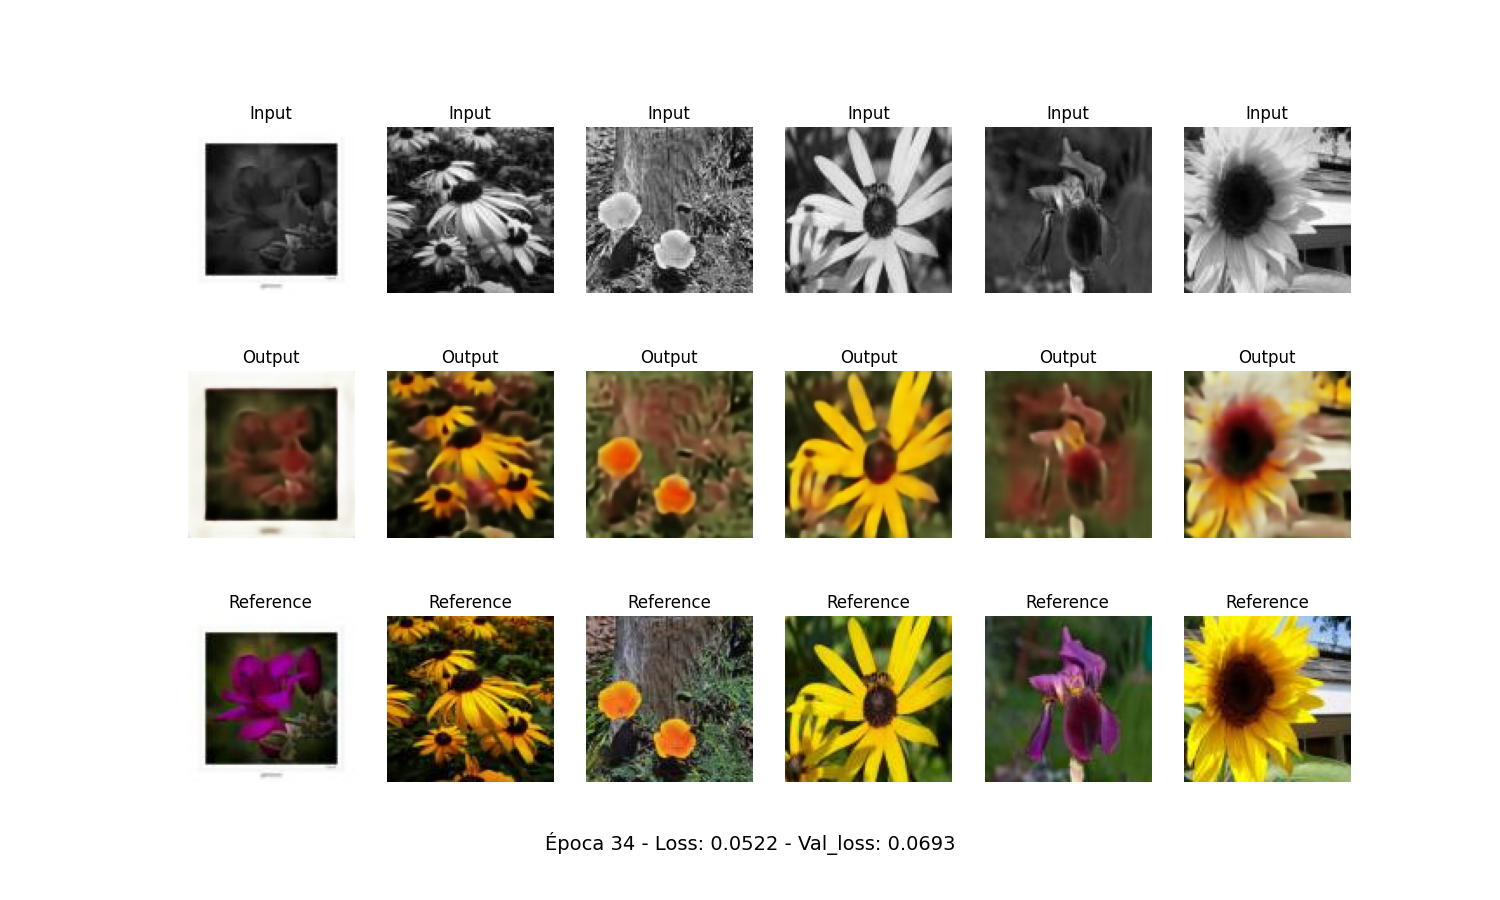

Epoch 1/300
355/355 [==============================] - 115s 276ms/step - loss: 0.0852 - val_loss: 0.0813
Epoch 2/300
355/355 [==============================] - 91s 257ms/step - loss: 0.0723 - val_loss: 0.0768
Epoch 3/300
355/355 [==============================] - 91s 257ms/step - loss: 0.0700 - val_loss: 0.0784
Epoch 4/300
355/355 [==============================] - 91s 257ms/step - loss: 0.0683 - val_loss: 0.0774
Epoch 5/300
355/355 [==============================] - 91s 257ms/step - loss: 0.0670 - val_loss: 0.0761
Epoch 6/300
355/355 [==============================] - 91s 257ms/step - loss: 0.0653 - val_loss: 0.0786
Epoch 7/300
355/355 [==============================] - 91s 257ms/step - loss: 0.0648 - val_loss: 0.0802
Epoch 8/300
355/355 [==============================] - 91s 257ms/step - loss: 0.0643 - val_loss: 0.0734
Epoch 9/300
355/355 [==============================] - 91s 257ms/step - loss: 0.0628 - val_loss: 0.0730
Epoch 10/300
355/355 [==============================] - 92s 259

In [12]:
import random
from tensorflow.keras.callbacks import EarlyStopping

# Callback para parada temprana
early_stop = EarlyStopping(monitor='val_loss',
                           patience=15,
                           restore_best_weights=True)

# Definimos el callback para visualizar
visualizer = ImageVisualizer(model, train_gray_img, train_color_img, show_images=6, draw_input=True)

model.fit(train_gray_img,
          train_color_img,
          validation_split=0.2,
          epochs = 300,
          batch_size = 32,
          verbose = 1,
          callbacks=[early_stop, visualizer])

model.save(MODELOS_DIR + 'Autoencoder_colorear_ej4.h5')

In [13]:
model.evaluate(test_gray_img, test_color_img)

50/50 [==============================] - 4s 70ms/step - loss: 0.0676


0.06760033965110779

## Visualizo resultados

50/50 [==============================] - 3s 66ms/step


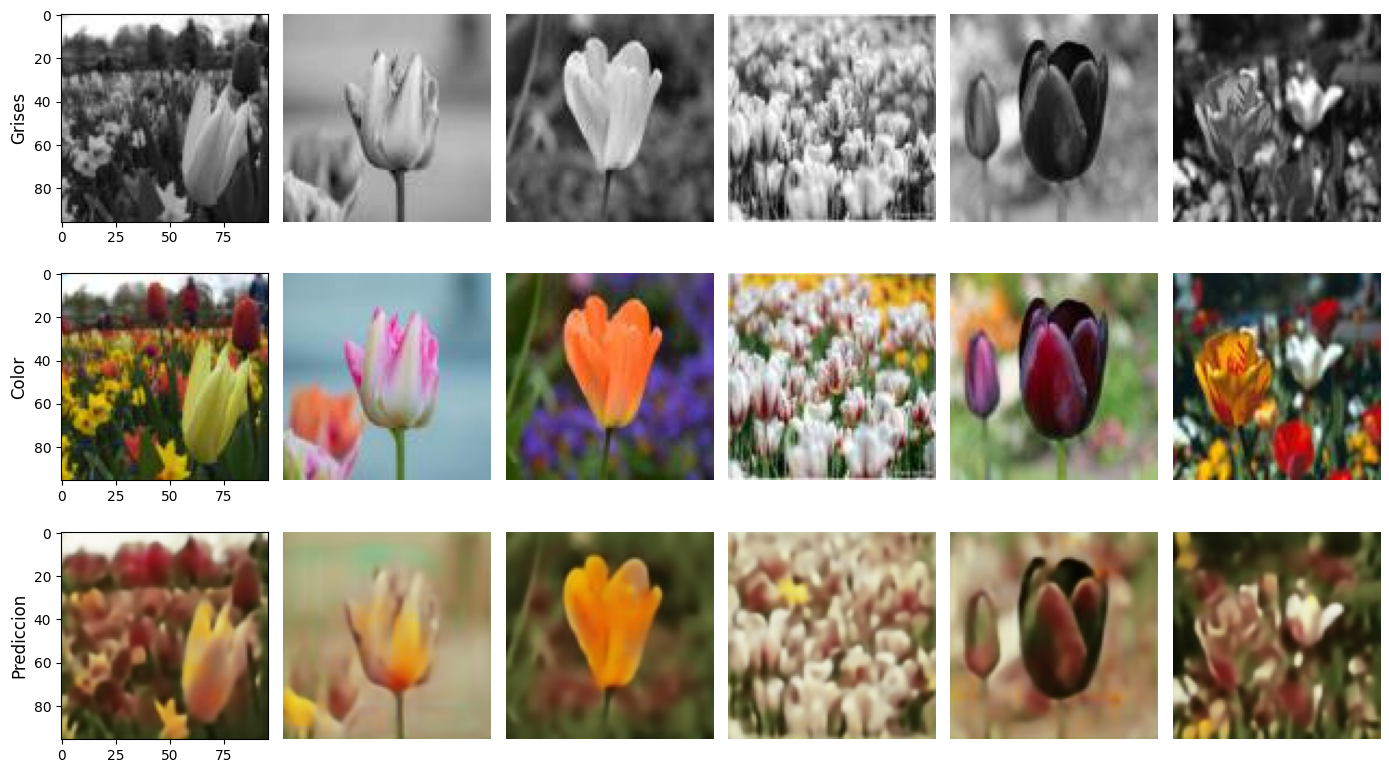

In [27]:
# Definir una función para mostrar imágenes en dos filas
def plot_images(grayscale_img, color_img, predicted_img, ini_img, num_img):

    fig, axes = plt.subplots(3, num_img, figsize=(14, 8))

    # Dibujar imágenes en escala de grises en la segunda fila
    for i in range(num_img):
        axes[0, i].imshow(grayscale_img[ini_img+i], cmap='gray')

        axes[0, i].axis('off')

     # Dibujar imágenes en color en la primera fila
    for i in range(num_img):
        axes[1, i].imshow(color_img[ini_img+i])
        axes[1, i].axis('off')

    # Dibujar imágenes en color en la primera fila
    for i in range(num_img):
        axes[2, i].imshow(predicted_img[ini_img+i])
        axes[2, i].axis('off')

    # Agregar títulos
    axes[0, 0].set_ylabel('Grises' , fontsize=12)
    axes[1, 0].set_ylabel('Color', fontsize=12)
    axes[2, 0].set_ylabel('Prediccion', fontsize=12)
    axes[0, 0].axis('on')
    axes[1, 0].axis('on')
    axes[2, 0].axis('on')

    plt.tight_layout()
    plt.show()


ini_imgs = 15
num_imgs = 6

# obtiene imágenes coloreadas del dataset de prueba a partir de imagenes en escala de grises
predicted_img = model.predict(test_gray_img)

plot_images(test_gray_img, test_color_img, predicted_img, ini_imgs, num_imgs)